In [89]:
import numpy as np
import matplotlib.pyplot as plot
import copy
#np.set_printoptions(threshold=np.nan) # Check why is this fuction
# To load the Temperature, time grid and space grid data
Temp = np.loadtxt("TemperatureProfile.dat", unpack = True) #(300*8520)
time = np.loadtxt("TemperatureProfile_time.dat", unpack = True) #8520
y_pos = np.loadtxt("TemperatureProfile_position.dat", unpack= True) #300
Heat_Flux = np.loadtxt("HeatFluxProfile.dat", unpack= True) #(300*8520)

In [90]:
### Data filttering-----------------------------------------------------------------------------------------
## In this section all nan value in the along the surface and the corresponding position are deleted 

row_ind_nan = np.array([]) # row_ind_nan stands for row indices with atleast one nan value
rownum = len(Temp) # row number of temperature profile
colnum = len(Temp[0]) # column number of temperature profile
for i in range(0,rownum):
    nan = 0
    inf = 0
    num = 0
    for j in range(0,colnum):
        if (np.isnan(Temp[i][j])== True):
            nan +=1     
        elif (np.isinf(Temp[i][j]) == True):
            inf +=1
        else:
            num +=1 
    if (nan >= 1):
        row_ind_nan = np.append(row_ind_nan,i)
        
        
row_ind_nan = row_ind_nan.astype(int)# converting from float to integer 
row_id_wout_nan = np.array([i for i in range(300) if i not in row_ind_nan]) #riwn stands for "Temp data having only row indice(number)
                                                                 # without nan" any rows containg any nan

Temp_data = Temp[row_id_wout_nan] # creating a ndarray deleting all rows having atleast one nan number

new_y_pos = y_pos[row_id_wout_nan]

In [91]:
material_length = 10 # length in cm say along x axis inside the material
x_grid_no = 300
x_pos = np.linspace(0,material_length,x_grid_no)
dx = x_pos[1]-x_pos[0]
y_grid_no = np.size(new_y_pos)

time_grid_no = np.size(time)
#To ccreate a Temperature Grid (Y * X)
#Here X-asix (second parameter in Temp_grid[j,i]) along the material-inside and Y-asix 
#(First parameter in Temp_grid[j,i]) along the surface
Temp_grid = np.zeros((y_grid_no+2,x_grid_no)) # the extra +2 along the Y-asix is for two boundary zero row 
                                                # on the upper and down side 
T_x_bound = 80 #Boundary values on the end-grid-points of x-axis 80C
Temp_grid[1:-1,-1] = T_x_bound # set the value at the end of x-asix and along the y-asix except the most upper and lower value 
Temp_grid[1:-1,0] = Temp_data[:,0]
dT = (Temp_grid[:,0] - Temp_grid[:,-1])/x_grid_no

#filing up the Temp_grid with initial data
for i in range(1,x_grid_no-1,1):
    Temp_grid[:,i] = Temp_grid[:,i-1] - dT[:]

#new_Temp_grid = np.zeros(np.shape(Temp_grid))
Heat_flux_obtained = np.zeros((y_grid_no,time_grid_no))

In [92]:
# kappa is the thermal conductivity
kappa = 197 # (Watt/meter . Kelvin)
#Heat Conductivity
Cp = 134 #J/Kg-K
#Mass density
Rho = 19.25e3 #Kg/mter cube
dt = time[1:]-time[0:-1]
dt = np.append(dt,dt[-1]) # Length of dt is 8520 where time grid no 8520
dy = new_y_pos[1:]-new_y_pos[0:-1] # Length of dy is 281 where length of new_y_pos 282
dy_extent = new_y_pos[-1]-new_y_pos[-2]
#dy =
dy = np.append(dy,dy_extent)
dy2 = np.square(dy)
dx2 = dx*dx

In [93]:
print(dy[0:10])
print(np.shape(dy2))
print(np.shape(dy))
print(np.shape(Temp_grid))

[0.00039482 0.00039482 0.00039482 0.00039482 0.00039482 0.00039482
 0.00039458 0.00039482 0.00039482 0.00039482]
(282,)
(282,)
(284, 300)


In [94]:
from decimal import Decimal, getcontext
getcontext().prec = 17
#dy2 = np.square(dy)

#Temp_grid = np.copy(Save_Tamp)
alpha = kappa/(Rho*Cp)
for k in range(0,time_grid_no): # k index number for corresponding time asix
    
    new_Temp_grid = np.zeros(np.shape(Temp_grid))
    update_Temp_grid = np.zeros(np.shape(Temp_grid))
    Temp_grid[1:-1,0] = (Temp_data[:,k])
    copy_Temp_grid = np.copy(Temp_grid)
    
    #for x in range(1, x_grid_no, 1):
     #   for y in range(1, y_grid_no, 1): 

    d2t_dx2 = dt[k]*(alpha*(copy_Temp_grid[:,2:] - 2*copy_Temp_grid[:,1:-1] + copy_Temp_grid[:,0:-2])/dx2)
    d2t_dy2 = dt[k]*alpha*(copy_Temp_grid[2:,:] - 2*copy_Temp_grid[1:-1,:] + copy_Temp_grid[0:-2,:])#/ np.transpose(dy)

    d2t_dy2 =np.transpose(np.transpose(d2t_dy2)/dy2)
    new_Temp_grid[1:-1, 1:-1] = d2t_dx2[1:-1,:] + d2t_dy2[:,1:-1]
    update_Temp_grid = Temp_grid + new_Temp_grid 
    Temp_grid = np.copy(update_Temp_grid)
    
    #Temp_grid = new_Temp_grid
    #Temp_grid[1:-1,:] += dt[k]*(alpha*(Temp_grid[2:,:] - 2*Temp_grid[1:-1,:] + Temp_grid[0:-2,:])/(dy[0])**2)
    #Calculate the heat flux-------------------------------------------------------------------------------------
    Heat_flux_obtained[:,k] = -1*kappa*(Temp_grid[1:-1,1] - Temp_grid[1:-1,0])/dy

In [95]:
print(np.shape(Temp_grid))

(284, 300)


In [96]:
print(Heat_flux_obtained[1,991:1000])
print(np.shape(Heat_flux_obtained))

[1.08666077e+08 1.08654724e+08 1.09313614e+08 1.09111375e+08
 1.09409674e+08 1.09872169e+08 1.09624734e+08 1.09896826e+08
 1.09388201e+08]
(282, 8520)


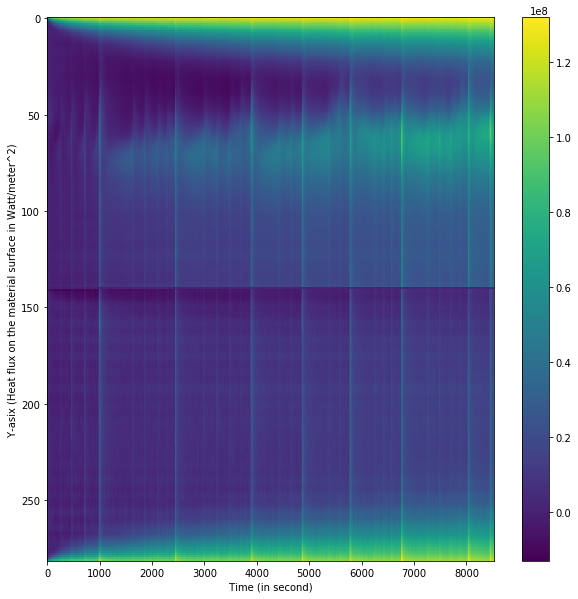

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10,10))
#ax = fig.add_subplot(1,1, xticks = [], yticks = [])
plt.imshow(Heat_flux_obtained, aspect="auto")
plt.xlabel(" Time (in second) ")
plt.ylabel(" Y-asix (Heat flux on the material surface in Watt/meter^2) ")
plt.colorbar()
plt.show()

In [33]:
print(1e-1)

0.1


In [100]:
print("m2")

m^2
